<a href="https://colab.research.google.com/github/yashk2000/Gridworld-RL/blob/main/Gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
!git clone https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction.git

Cloning into 'DeepReinforcementLearningInAction'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 184 (delta 25), reused 58 (delta 13), pack-reused 99
Receiving objects: 100% (184/184), 3.00 MiB | 26.69 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [74]:
!mv "/content/DeepReinforcementLearningInAction/Chapter 3" /content/Chapter3

In [75]:
!rm -rf /content/DeepReinforcementLearningInAction/

In [76]:
!mv /content/Chapter3/GridBoard.py /content/GridBoard.py
!mv /content/Chapter3/Gridworld.py /content/Gridworld.py
!mv /content/Chapter3/Ch3_book.ipynb /content/ch3.ipynb

In [77]:
!rm -rf Chapter3

## Importing the game environment from the `Gridworld.py` file

In [78]:
from Gridworld import *

In [79]:
game = Gridworld(size=4, mode='static')
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [80]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [81]:
game.reward()

-1

In [82]:
game.makeMove('l')
game.makeMove('u')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', 'P', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [83]:
game.reward()

-1

In [84]:
game.makeMove('l')
game.makeMove('u')
game.makeMove('u')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [85]:
game.reward()

10

In [86]:
game.board.render_np()

array([[[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

The game board is composed of 4 different 4*4 tensors. Each tensor has 1s and 0s, the 1s representing either the player, the wall or the win or lose position in each tensor. 

In [87]:
game.board.render_np().shape

(4, 4, 4)

In [88]:
import torch.nn as nn
import torch.nn.functional as F

class QNet(nn.Module):
  def __init__(self, l1=64, l2=150, l3=100, l4=4):
    super().__init__()
    self.linear1 = nn.Linear(l1, l2)
    self.linear2 = nn.Linear(l2, l3)
    self.linear3 = nn.Linear(l3, l4)

  def forward(self, x):
    out = F.relu(self.linear1(x))
    out = F.relu(self.linear2(out)) 
    out = self.linear3(out)  
    return out 

In [89]:
import numpy as np
from Gridworld import Gridworld
import random
from matplotlib import pylab as plt

l1 = 64
l2 = 150 
l3 = 100
l4 = 4

model = QNet(l1, l2, l3, l4)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Since the neural network can't generate character, we need  to a set which matches the numbers generated to character. 

In [90]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [91]:
gamma = 0.9
epsilon = 1.0

epochs = 1000
losses = []
for i in range(epochs):
  game = Gridworld(size=4, mode='static')
  state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
  state1 = torch.from_numpy(state_).float()
  status = 1
  while (status == 1):
    qval = model(state1)
    qval_ = qval.data.numpy()
    if (random.random() < epsilon):
      action_ = np.random.randint(0, 4)
    else: 
      action_ = np.argmax(qval_)
    
    action = action_set[action_]
    game.makeMove(action)
    state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state2 = torch.from_numpy(state2_).float()
    reward = game.reward()
    with torch.no_grad():
      newQ = model(state2.reshape(1, 64))
    maxQ = torch.max(newQ)
    if reward == -1:
      Y = reward + (gamma * maxQ)
    else: 
      Y = reward
    
    Y = torch.Tensor([Y]).detach()
    X = qval.squeeze()[action_]
    loss = loss_fn(X, Y)
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    state1 = state2
    if reward != -1:
      status = 0

  if epsilon > 0.1: 
    epsilon -= (1 / epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Text(0, 0.5, 'Loss')

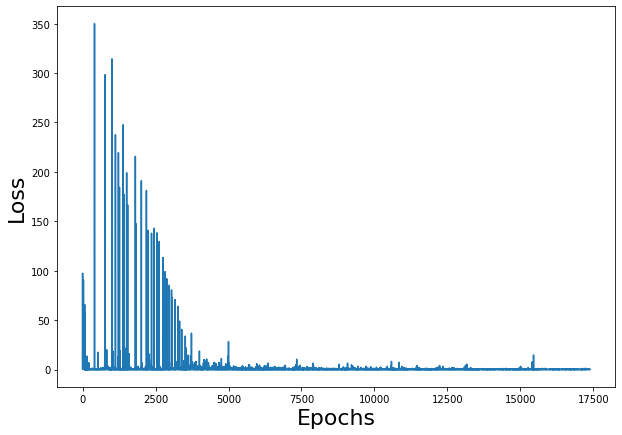

In [92]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [93]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

In [94]:
test_model(model, 'static')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

In [95]:
test_model(model, 'random')

Initial State:
[[' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' 'P' ' ' ' ']
 ['+' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 1; Taking action: u
[[' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 5; Taking action: l
[['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 6; Taking action: l
[['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['+' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 7; Taking action: d
[[' ' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']
 ['+' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 8; Taking action: u
[['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [

False

## Train with random mode

In [96]:
gamma = 0.9
epsilon = 1.0

epochs = 1000
losses = []
for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
  state1 = torch.from_numpy(state_).float()
  status = 1
  while (status == 1):
    qval = model(state1)
    qval_ = qval.data.numpy()
    if (random.random() < epsilon):
      action_ = np.random.randint(0, 4)
    else: 
      action_ = np.argmax(qval_)
    
    action = action_set[action_]
    game.makeMove(action)
    state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state2 = torch.from_numpy(state2_).float()
    reward = game.reward()
    with torch.no_grad():
      newQ = model(state2.reshape(1, 64))
    maxQ = torch.max(newQ)
    if reward == -1:
      Y = reward + (gamma * maxQ)
    else: 
      Y = reward
    
    Y = torch.Tensor([Y]).detach()
    X = qval.squeeze()[action_]
    loss = loss_fn(X, Y)
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    state1 = state2
    if reward != -1:
      status = 0

  if epsilon > 0.1: 
    epsilon -= (1 / epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Text(0, 0.5, 'Loss')

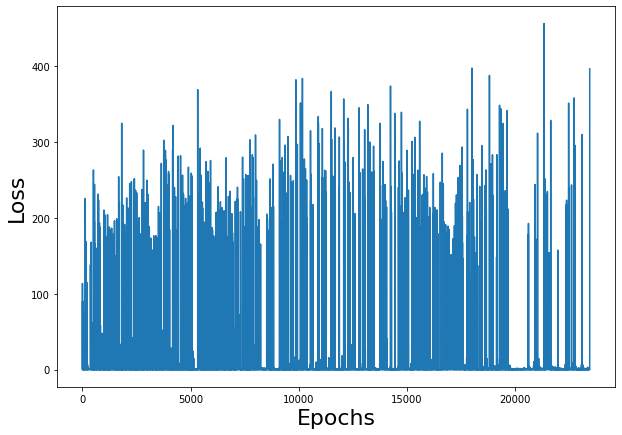

In [97]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

## Train with player mode

In [98]:
gamma = 0.9
epsilon = 1.0

epochs = 1000
losses = []
for i in range(epochs):
  game = Gridworld(size=4, mode='player')
  state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
  state1 = torch.from_numpy(state_).float()
  status = 1
  while (status == 1):
    qval = model(state1)
    qval_ = qval.data.numpy()
    if (random.random() < epsilon):
      action_ = np.random.randint(0, 4)
    else: 
      action_ = np.argmax(qval_)
    
    action = action_set[action_]
    game.makeMove(action)
    state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state2 = torch.from_numpy(state2_).float()
    reward = game.reward()
    with torch.no_grad():
      newQ = model(state2.reshape(1, 64))
    maxQ = torch.max(newQ)
    if reward == -1:
      Y = reward + (gamma * maxQ)
    else: 
      Y = reward
    
    Y = torch.Tensor([Y]).detach()
    X = qval.squeeze()[action_]
    loss = loss_fn(X, Y)
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    state1 = state2
    if reward != -1:
      status = 0

  if epsilon > 0.1: 
    epsilon -= (1 / epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Text(0, 0.5, 'Loss')

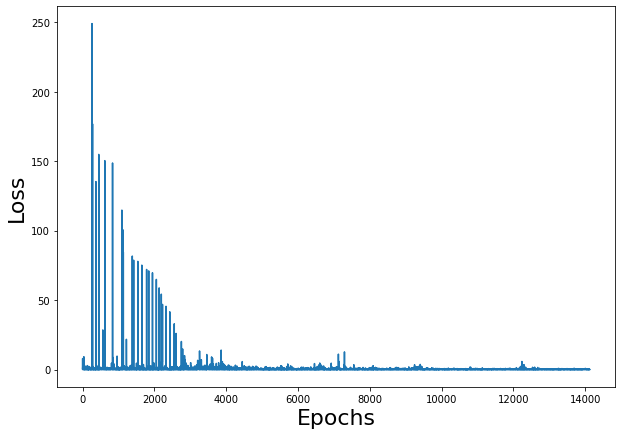

In [99]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [100]:
test_model(model, 'player')

Initial State:
[['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

In [101]:
test_model(model, 'static')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

In [102]:
test_model(model, 'random')

Initial State:
[[' ' ' ' '-' ' ']
 [' ' ' ' 'W' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 0; Taking action: d
[[' ' ' ' '-' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' '+' ' ']]
Move #: 1; Taking action: d
[[' ' ' ' '-' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' 'P']]
Move #: 2; Taking action: u
[[' ' ' ' '-' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' '+' ' ']]
Move #: 3; Taking action: d
[[' ' ' ' '-' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' 'P']]
Move #: 4; Taking action: d
[[' ' ' ' '-' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' 'P']]
Move #: 5; Taking action: u
[[' ' ' ' '-' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' '+' ' ']]
Move #: 6; Taking action: d
[[' ' ' ' '-' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' 'P']]
Move #: 7; Taking action: d
[[' ' ' ' '-' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' 'P']]
Move #: 8; Taking action: u
[[' ' ' ' '-' ' ']
 [' ' ' ' 'W' ' ']
 [

False

In [122]:
import numpy as np
from Gridworld import Gridworld
import random
from matplotlib import pylab as plt

l1 = 64
l2 = 150 
l3 = 100
l4 = 4

model = QNet(l1, l2, l3, l4)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [123]:
gamma = 0.9
epsilon = 0.3

from collections import deque
epochs = 5000
losses = []
mem_size = 1000 
batch_size = 200 
replay = deque(maxlen=mem_size) 
max_moves = 50 

for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1) 
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): 
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done) 
        replay.append(exp) 
        state1 = state2
        
        if len(replay) > batch_size: 
            minibatch = random.sample(replay, batch_size) 
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) 
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model(state2_batch) 
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) 
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves: 
            status = 0
            mov = 0
            
losses = np.array(losses)

Streaming output truncated to the last 5000 lines.
4016 0.12134139239788055
4017 0.061455897986888885
4017 0.046067528426647186
4017 0.048196788877248764
4017 0.06014516204595566
4017 0.06817901134490967
4017 0.11496767401695251
4017 0.09694801270961761
4017 0.04698409140110016
4017 0.10336752980947495
4017 0.04696435481309891
4017 0.04445086419582367
4017 0.09369723498821259
4017 0.06840039789676666
4017 0.05644553154706955
4017 0.06896719336509705
4017 0.06148345395922661
4018 0.07028141617774963
4018 0.0616944395005703
4019 0.0657130628824234
4020 0.05234689265489578
4021 0.04589758813381195
4021 0.06475277990102768
4021 0.46998611092567444
4021 0.4459952414035797
4022 0.06509844958782196
4022 0.05141665041446686
4022 0.3533689081668854
4022 0.057301782071590424
4022 0.05682877078652382
4022 0.32457005977630615
4023 0.26461493968963623
4023 0.2217586487531662
4023 0.0610634945333004
4023 0.1921050101518631
4024 0.08428394049406052
4024 0.05380937457084656
4025 0.05976115167140961
40

Text(0, 0.5, 'Loss')

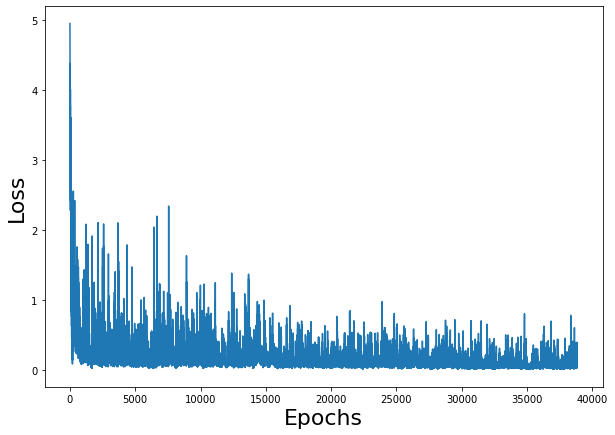

In [124]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [132]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 894
Win percentage: 89.4%


In [142]:
import copy

l1 = 64
l2 = 150
l3 = 100
l4 = 4


model = QNet(l1, l2, l3, l4)

model2 = copy.deepcopy(model) 
model2.load_state_dict(model.state_dict()) 

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [143]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0
sync_freq = 500 
j=0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        j+=1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp) 
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch) 
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0: 
                model2.load_state_dict(model.state_dict())
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
        
losses = np.array(losses)

Streaming output truncated to the last 5000 lines.
3986 0.012559293769299984
3987 0.015214302577078342
3988 0.02030278369784355
3988 0.010693371295928955
3988 0.015599665232002735
3988 0.018823368474841118
3988 0.028533732518553734
3988 0.027943355962634087
3988 0.013178851455450058
3989 0.0216011144220829
3990 0.0142857376486063
3991 0.019352614879608154
3991 0.025913305580615997
3991 0.01635315641760826
3991 0.04331672564148903
3991 0.02312803454697132
3991 0.03634615242481232
3991 0.011519347317516804
3991 0.050243034958839417
3991 0.018776018172502518
3991 0.011982632800936699
3991 0.012323406524956226
3991 0.00914702657610178
3991 0.023686321452260017
3991 0.01665741391479969
3991 0.017485875636339188
3991 0.022424709051847458
3991 0.017628522589802742
3991 0.013821206986904144
3991 0.014914197847247124
3992 0.0070600141771137714
3992 0.015917206183075905
3993 0.0050147478468716145
3994 0.01270996406674385
3995 0.011768701486289501
3995 0.01007916685193777
3995 0.01536096446216106

Text(0, 0.5, 'Loss')

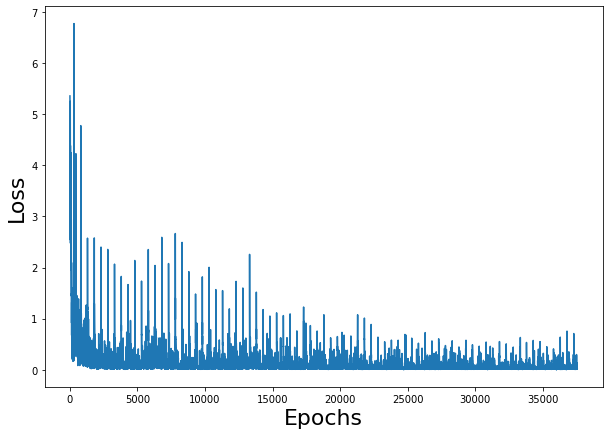

In [136]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [138]:
test_model(model, 'random')

Initial State:
[['W' ' ' 'P' ' ']
 [' ' ' ' '-' ' ']
 ['+' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: r
[['W' ' ' ' ' 'P']
 [' ' ' ' '-' ' ']
 ['+' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['W' ' ' ' ' ' ']
 [' ' ' ' '-' 'P']
 ['+' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[['W' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']
 ['+' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['W' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']
 ['+' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['W' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']
 ['+' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: l
[['W' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']
 ['+' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

In [151]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 924
Win percentage: 92.4%
